In [1]:
from snake import SnakeGame

In [2]:
import sys
import pylab
import random
import numpy as np
from collections import deque

import torch
from torch import nn, optim
import torch.nn.functional as F

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

        if self.load_model:
            self.model.load_state_dict(torch.load(
                './snake_dqn_trained.bin'))
    
    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size),
        )
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            # 무작위 행동 반환
            return torch.LongTensor([[random.randrange(4)]])
        else:
            # 모델로부터 행동 산출
            return self.model(state).data.max(1)[1].view(1, 1)

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        # reward = torch.FloatTensor([reward])
        # next_state = torch.FloatTensor([next_state])
        # done = torch.FloatTensor([done])
        reward = torch.FloatTensor(np.array([reward]))
        next_state = torch.FloatTensor(np.array([next_state]))
        done = torch.FloatTensor(np.array([done]))

        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        dones = torch.cat(dones)

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        current_q = self.model(states).gather(1, actions)
        max_next_q = self.target_model(next_states).detach().max(1)[0]
        expected_q = rewards + (self.discount_factor * max_next_q)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        self.optimizer.zero_grad()

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        loss.backward()

        self.optimizer.step()


In [4]:
# batch = random.sample(agent.memory, agent.batch_size) # 64
# states, actions, rewards, next_states, dones = zip(*batch)

# # print(states)
# print(len(states), states[0].shape)
# states = torch.cat(states)
# actions = torch.cat(actions)
# rewards = torch.cat(rewards)
# next_states = torch.cat(next_states)
# dones = torch.cat(dones)

# print(states)
# print(states.shape) # 57600 == 900 * 64
# print(agent.model)

# agent.model(states) #ERROR!

# # current_q = agent.model(states).gather(1, actions)
# # max_next_q = agent.target_model(next_states).detach().max(1)[0]
# # expected_q = rewards + (agent.discount_factor * max_next_q)

episode: 0   score: -100   memory length: 4   epsilon: 1.0
episode: 1   score: -100   memory length: 5   epsilon: 1.0
episode: 2   score: -100   memory length: 40   epsilon: 1.0
episode: 3   score: -100   memory length: 74   epsilon: 1.0
episode: 4   score: -100   memory length: 95   epsilon: 1.0
episode: 5   score: -100   memory length: 96   epsilon: 1.0
episode: 6   score: -100   memory length: 111   epsilon: 1.0
episode: 7   score: -100   memory length: 148   epsilon: 1.0
episode: 8   score: -100   memory length: 176   epsilon: 1.0
episode: 9   score: -100   memory length: 224   epsilon: 1.0
episode: 10   score: -100   memory length: 234   epsilon: 1.0
episode: 11   score: -100   memory length: 238   epsilon: 1.0
episode: 12   score: -100   memory length: 275   epsilon: 1.0
episode: 13   score: -90   memory length: 287   epsilon: 1.0
episode: 14   score: -100   memory length: 299   epsilon: 1.0
episode: 15   score: -90   memory length: 312   epsilon: 1.0
episode: 16   score: -100   

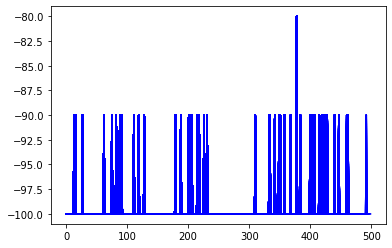

In [5]:
EPISODES = 500

env = SnakeGame()
state_size = env.state_size
action_size = env.action_size

agent = DQNAgent(state_size, action_size)
scores, episodes = [], []

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    
    while not done:
        # if e % 100 == 0:
            # env.render()
        
        # state = torch.FloatTensor([state]) # 이렇게 하면 느리다고 워닝뜸
        state = torch.FloatTensor(np.array([state]))
        action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        agent.append_sample(state, action, reward, next_state, done)
        if len(agent.memory) > agent.train_start:
            agent.train_model()
        
        score += reward
        state = next_state
        
        if done:
            agent.update_target_model()
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig('./snake_dqn.png')
            print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)